## Using time series for predictive mainteneance of turbofan engines

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Data import
data_dir = "../../data/CMAPSSData/"

In [3]:
sensor_colnames = [f"sensor{i}" for i in range(1,22, 1)]

In [4]:
engine_colnames = ["unit_number", "cycles", "operational_setting_1", "operational_setting_2", "operational_setting_3"] + sensor_colnames

In [5]:
train_fd001_raw = pd.read_csv(f"{data_dir}train_FD001.txt", delim_whitespace=True, names=engine_colnames)
train_fd002_raw = pd.read_csv(f"{data_dir}train_FD002.txt", delim_whitespace=True, names=engine_colnames)
train_fd003_raw = pd.read_csv(f"{data_dir}train_FD003.txt", delim_whitespace=True, names=engine_colnames)
train_fd004_raw = pd.read_csv(f"{data_dir}train_FD004.txt", delim_whitespace=True, names=engine_colnames)

In [6]:
test_fd001_raw = pd.read_csv(f"{data_dir}test_FD001.txt", delim_whitespace=True, names=engine_colnames)
test_fd002_raw = pd.read_csv(f"{data_dir}test_FD002.txt", delim_whitespace=True, names=engine_colnames)
test_fd003_raw = pd.read_csv(f"{data_dir}test_FD003.txt", delim_whitespace=True, names=engine_colnames)
test_fd004_raw = pd.read_csv(f"{data_dir}test_FD004.txt", delim_whitespace=True, names=engine_colnames)

In [7]:
rul_fd001_raw = pd.read_csv(f"{data_dir}RUL_FD001.txt", names=["rul_fd001"], squeeze=True)
rul_fd002_raw = pd.read_csv(f"{data_dir}RUL_FD002.txt", names=["rul_fd002"], squeeze=True)
rul_fd003_raw = pd.read_csv(f"{data_dir}RUL_FD003.txt", names=["rul_fd003"], squeeze=True)
rul_fd004_raw = pd.read_csv(f"{data_dir}RUL_FD004.txt", names=["rul_fd004"], squeeze=True)

In [8]:
rul_df = pd.DataFrame({"rul_fd001": rul_fd001_raw, "rul_fd002": rul_fd002_raw, "rul_fd003": rul_fd003_raw, "rul_fd004": rul_fd004_raw}, dtype=int)

In [9]:
#rul_fd001_raw

In [10]:
#rul_df

### Assumptions

- data in rul_ are useful life of a particular unit
- unit number and trejectories are synonyms
- data in rul_ are ordered by thier unit number
- rul_df represent test set remaining useful life

In [10]:
rul_df["unit_number"] = list(range(1, rul_df.shape[0] + 1))

In [11]:
cols = rul_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
rul_df = rul_df[cols]

In [12]:
rul_df = rul_df.set_index("unit_number")

In [13]:
rul_raw = pd.concat([rul_fd001_raw, rul_fd002_raw, rul_fd003_raw, rul_fd004_raw], axis=0)
rul_raw.name = "all_test_data"

### Model data transformation

In [14]:
train_fd001 = train_fd001_raw.copy()
train_fd002 = train_fd002_raw.copy()
train_fd003 = train_fd003_raw.copy()
train_fd004 = train_fd004_raw.copy()

In [15]:
test_fd001 = test_fd001_raw.copy()
test_fd002 = test_fd002_raw.copy()
test_fd003 = test_fd003_raw.copy()
test_fd004 = test_fd004_raw.copy()

In [16]:
# assuming linear reduction on remaining useful life
train_fd001["rul"] = train_fd001.groupby(["unit_number"], group_keys=False).apply(lambda g: max(g.cycles) - g.cycles)
train_fd002["rul"] = train_fd002.groupby(["unit_number"], group_keys=False).apply(lambda g: max(g.cycles) - g.cycles)
train_fd003["rul"] = train_fd003.groupby(["unit_number"], group_keys=False).apply(lambda g: max(g.cycles) - g.cycles)
train_fd004["rul"] = train_fd004.groupby(["unit_number"], group_keys=False).apply(lambda g: max(g.cycles) - g.cycles)

In [17]:
train_fd001["dataset"] = "fd001"
train_fd002["dataset"] = "fd002"
train_fd003["dataset"] = "fd003"
train_fd004["dataset"] = "fd004"

In [18]:
test_fd001["dataset"] = "fd001"
test_fd002["dataset"] = "fd002"
test_fd003["dataset"] = "fd003"
test_fd004["dataset"] = "fd004"

In [19]:
train = pd.concat([train_fd001, train_fd002, train_fd003, train_fd004], axis=0)

In [20]:
train = train.set_index([ "dataset", "unit_number", "cycles"])

In [21]:
test = pd.concat([test_fd001, test_fd002, test_fd003, test_fd004], axis=0)

In [22]:
test = test.set_index([ "dataset", "unit_number", "cycles"])

In [23]:
# How to index into the training set
# Select the first unit of fd001 dataset # Can unstack with tarain.unstack()
train.loc[("fd001", 1)]

,operational_setting_1,operational_setting_2,operational_setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul
cycles,,,,,,,,,,,,,,,,,,,,,
1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,...,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2


### Using clipped RUL
Assuming cliiped RUL over one that decreases linearly overtime may better reflect real operating condtions. See 

https://towardsdatascience.com/the-importance-of-problem-framing-for-supervised-predictive-maintenance-solutions-cc8646826093

Training done only on the fd001 dataset

In [24]:
train["rul_clipped"] = train.rul.clip(upper=125)

In [25]:
train["rul_clipped"]

dataset  unit_number  cycles
fd001    1            1         125
                      2         125
                      3         125
                      4         125
                      5         125
                               ... 
fd004    249          251         4
                      252         3
                      253         2
                      254         1
                      255         0
Name: rul_clipped, Length: 160359, dtype: int64

### Model using time series

### Examples of how to index into multi index pandas dataframe

train.loc["fd001"]#["unit_number"]

train.loc[("fd001", 1), :]

train.loc[("fd001", slice(None)), :]

In [27]:
def plot_feature(dataset, unit, feature):
    #plt.figure(figsize=(12, 6))
    #plt.plot("rul", "sensor2", data=train.loc[("fd001", 1)])
    #plt.plot("rul", feature, data=train.loc[(dataset, unit)])
    plt.plot(feature, data=train.loc[(dataset, unit)])
    #plt.xlim(0, 250)
    plt.xlabel("cycles")
    plt.ylabel(feature)

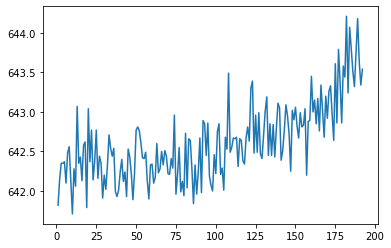

In [28]:
plt.plot("sensor2", data=train.loc[("fd001", 1)]);

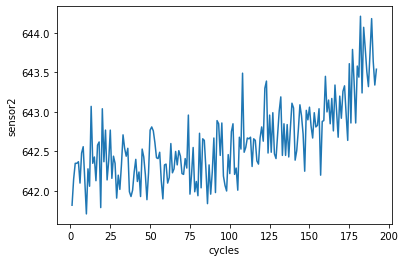

In [29]:
plot_feature("fd001", 1, "sensor2");

### Creating lag variables for the time series

In [30]:
drop_sensors = ['sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19']
drop_settings =  ["operational_setting_1", "operational_setting_2", "operational_setting_3"]
drop_targets = ["rul"] # ["rul", rul_clipped"]
drop_labels = drop_sensors + drop_settings + drop_targets
drop_test_labels = drop_sensors + drop_settings

In [59]:
def get_training_data(df, dataset = "fd001"):
   
    if dataset:
        Xtrain = df.loc[(dataset)].drop(drop_labels, axis=1)
    else:
        Xtrain = df.drop(drop_labels, axis=1)
        print(f"No training set provided.  Using entire dataset")
    
    remaining_sensors = list(Xtrain.columns.difference(["rul", "rul_clipped"]))
    lag1 = [col + '_lag_1' for col in remaining_sensors]
    Xtrain[lag1] = Xtrain[remaining_sensors].shift(1)
    
    Xtrain.dropna(inplace=True)
    ytrain = Xtrain.pop('rul_clipped')
    
    return Xtrain, ytrain, remaining_sensors

In [60]:
Xtrain, ytrain, remaining_sensors = get_training_data(train, dataset = "fd001")

### Model training and fitting

In [67]:
lm_fd001 = LinearRegression()
lm_fd001.fit(Xtrain, ytrain)

LinearRegression()

### Model evaluation using RMSE

In [52]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat, squared = False)
    variance = r2_score(y_true, y_hat)
    print(f'{label} set RMSE:{mse:.2f}, R2:{variance:.2f}')

## Setting up test set

In [97]:
def get_test_data(df, dataset = "fd001"):
    if dataset:
        Xtest = df.loc[(dataset)].drop(drop_test_labels, axis=1)
    else:
        Xtest = df.drop(drop_test_labels, axis=1)
        print(f"No training set provided.  Using entire dataset")
        
    lag1 = [col + '_lag_1' for col in remaining_sensors]
    Xtest[lag1] = Xtest[remaining_sensors].shift(1)
    Xtest.dropna(inplace=True)
    Xtest_last_cycle = Xtest.groupby(level='unit_number').last()
    
    return Xtest_last_cycle

Test data are for remaining useful life is only provided for the last time cycle.

In [180]:
Xtest_fd001 = get_test_data(test, dataset = "fd001")

In [181]:
y_hat_test = lm_fd001.predict(Xtest_fd001)

### Result for fd001

For fd001 we have a RMSE of 21.75 cycles with a datset mean of 75.5 cycles and median of 86 cycles

In [182]:
evaluate(rul_fd001_raw, y_hat_test, label='test')

test set RMSE:21.76, R2:0.73


count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: rul_fd001, dtype: float64

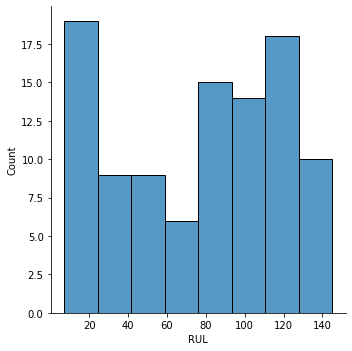

In [184]:
ax = sns.displot(rul_fd001_raw);
ax.set(xlabel = "RUL");
rul_fd001_raw.describe()

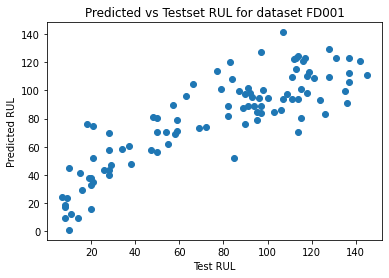

In [185]:
plt.scatter(rul_fd001_raw, y_hat_test)
plt.xlabel("Test RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Testset RUL for dataset FD001");

## Using time series to train and fit on the FD002 data set

In [186]:
Xtrain, ytrain, remaining_sensors = get_training_data(train, dataset = "fd002")

In [187]:
lm_fd002 = LinearRegression()
lm_fd002.fit(Xtrain, ytrain)

LinearRegression()

In [188]:
Xtest_fd002 = get_test_data(test, dataset = "fd002")

In [189]:
y_hat_test = lm_fd002.predict(Xtest_fd002)

In [190]:
evaluate(rul_fd002_raw, y_hat_test, label='test')

test set RMSE:32.00, R2:0.65


count    259.000000
mean      81.185328
std       53.882916
min        6.000000
25%       35.000000
50%       80.000000
75%      121.000000
max      194.000000
Name: rul_fd002, dtype: float64

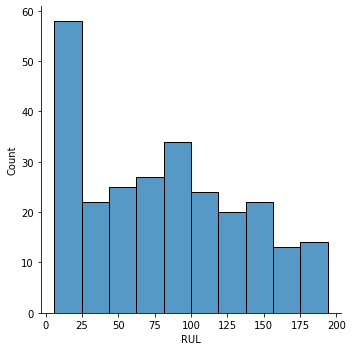

In [191]:
ax = sns.displot(rul_fd002_raw);
ax.set(xlabel = "RUL");
rul_fd002_raw.describe()

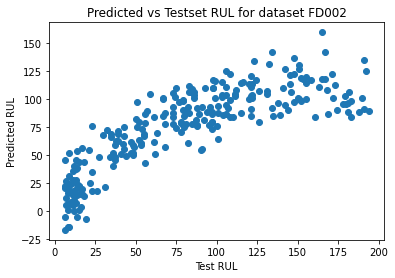

In [192]:
plt.scatter(rul_fd002_raw, y_hat_test)
plt.xlabel("Test RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Testset RUL for dataset FD002");

### Result for fd002

For fd002 we have a RMSE of 32 cycles with a dataset mean of 81 cycles and median of 80 cycles

## Using time series to train and fit on the FD003 data set

In [193]:
Xtrain, ytrain, remaining_sensors = get_training_data(train, dataset = "fd003")

In [194]:
lm_fd003 = LinearRegression()
lm_fd003.fit(Xtrain, ytrain)

LinearRegression()

In [195]:
Xtest_fd003 = get_test_data(test, dataset = "fd003")

In [196]:
y_hat_test = lm_fd003.predict(Xtest_fd003)

In [197]:
evaluate(rul_fd003_raw, y_hat_test, label='test')

test set RMSE:22.53, R2:0.70


count    100.000000
mean      75.320000
std       41.604166
min        6.000000
25%       43.250000
50%       77.500000
75%      115.000000
max      145.000000
Name: rul_fd003, dtype: float64

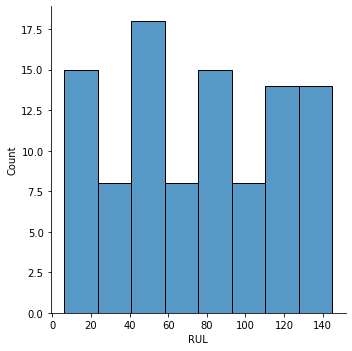

In [198]:
ax = sns.displot(rul_fd003_raw);
ax.set(xlabel = "RUL");
rul_fd003_raw.describe()

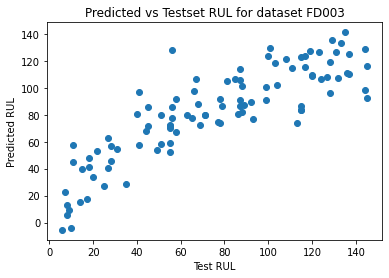

In [199]:
plt.scatter(rul_fd003_raw, y_hat_test)
plt.xlabel("Test RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Testset RUL for dataset FD003");

### Result for fd003

For fd003 we have a RMSE of 22.5 cycles with a dataset mean of 75 cycles and median of 77.5 cycles

## Using time series to train and fit on the FD004 data set

In [200]:
Xtrain, ytrain, remaining_sensors = get_training_data(train, dataset = "fd004")

In [201]:
lm_fd004 = LinearRegression()
lm_fd004.fit(Xtrain, ytrain)

LinearRegression()

In [202]:
Xtest_fd004 = get_test_data(test, dataset = "fd004")

In [203]:
y_hat_test = lm_fd004.predict(Xtest_fd004)

In [204]:
evaluate(rul_fd004_raw, y_hat_test, label='test')

test set RMSE:39.27, R2:0.48


count    248.000000
mean      86.552419
std       54.634054
min        6.000000
25%       36.000000
50%       88.000000
75%      126.750000
max      195.000000
Name: rul_fd004, dtype: float64

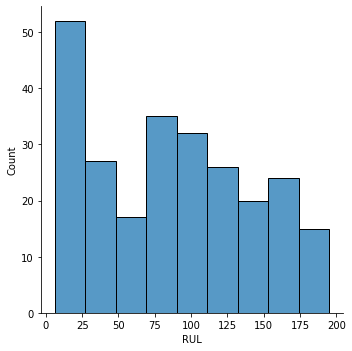

In [205]:
ax = sns.displot(rul_fd004_raw);
ax.set(xlabel = "RUL");
rul_fd004_raw.describe()

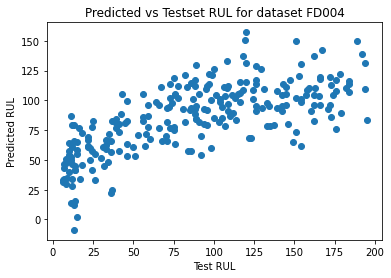

In [206]:
plt.scatter(rul_fd004_raw, y_hat_test)
plt.xlabel("Test RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Testset RUL for dataset FD004");

### Result for fd004

For fd004 we have a RMSE of 39 cycles with a dataset mean of 86.5 cycles and median of 80 cycles

## Using time series to train and fit on the full data set

In [207]:
Xtrain, ytrain, remaining_sensors = get_training_data(train, dataset = None)

No training set provided.  Using entire dataset


In [208]:
lm_full = LinearRegression()
lm_full.fit(Xtrain, ytrain)

LinearRegression()

In [209]:
nwtest = test.reset_index(level=["dataset", "unit_number", "cycles"], drop=False)

In [210]:
nwtest["data_unit"] = nwtest.dataset + nwtest.unit_number.astype(str)

In [211]:
nwtest = nwtest.set_index(["data_unit", "cycles"]).drop(["dataset", "unit_number"], axis=1)

In [212]:
nwtest.index.rename({"data_unit": "unit_number"}, inplace=True)

In [213]:
Xtest_full = get_test_data(nwtest, dataset = None)

No training set provided.  Using entire dataset


In [214]:
y_hat_test = lm_full.predict(Xtest_full)

In [215]:
evaluate(rul_raw, y_hat_test, label='test')

test set RMSE:59.86, R2:-0.37


count    707.000000
mean      81.437058
std       51.108532
min        6.000000
25%       36.000000
50%       83.000000
75%      119.000000
max      195.000000
Name: all_test_data, dtype: float64

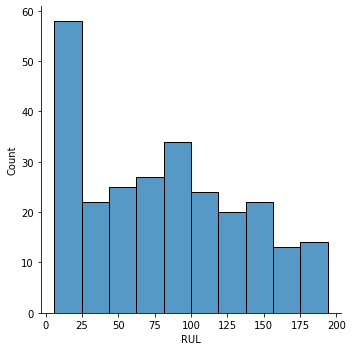

In [216]:
ax = sns.displot(rul_fd002_raw);
ax.set(xlabel = "RUL");
rul_raw.describe()

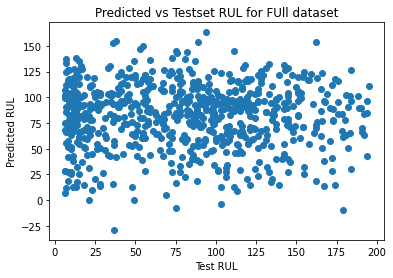

In [218]:
plt.scatter(rul_raw, y_hat_test)
plt.xlabel("Test RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Testset RUL for FUll dataset");